<a href="https://colab.research.google.com/github/Al-Tayeb96/Cirrhosis-Prediction-Project-4---Part-1-Core-/blob/main/Project_4_Part_1_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project_4_Part_1_(Core)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install collinearity

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer,make_column_selector

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Setting options
n=800
pd.set_option('display.max_columns',n)
pd.set_option("display.max_info_rows", n)
pd.set_option('display.max_info_columns',n)
from sklearn import set_config
set_config(transform_output='pandas')


from collinearity import SelectNonCollinear

from sklearn.feature_selection import VarianceThreshold




#costume functions

In [4]:
def explore_numeric(df, x, figsize=(6,5) ):
  # Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])
  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])
  ## Adding a title
  axes[0].set_title(f"Column: {x}")
  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()
  ## Print message with info on the count and % of null values
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")



def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
  """Source: https://login.codingdojo.com/m/606/13765/117604"""
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}")

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax



In [5]:
# Updated plot_categorical_vs_target function that includes option for classification task
def plot_categorical_vs_target(df, x, y, figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None, target_type='reg'):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  # REGRESSION-TARGET PLOT
  if target_type=='reg': #Added if statement here
    # Barplot
    sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
                linewidth=1, edgecolor='black', errorbar=None)
    # Boxplot
    sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                  order=order, hue_order=order, legend=False,
                  edgecolor='white', linewidth=0.5,
                  size=3,zorder=0)
  # CLASSIFICATION-TARGET PLOT # This is the new code for the classification task
  elif target_type=='class':
    ax = sns.histplot(data=temp_df, hue=y, x=x, stat='percent',  multiple='fill')
  # Rotate xlabels
  ax.set_xticks(ax.get_xticks()) # Added this to prevent a bug
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax


In [6]:
# Updating the function
def plot_numeric_vs_target(df, x, y, figsize=(6,4),
                           target_type='reg', estimator='mean',
                           errorbar='ci',sorted=False,ascending=False,
                           **kwargs): # kwargs for sns.regplot

  nulls = df[[x,y]].isna().sum()
  if nulls.sum()>0:
    print(f"- Excluding {nulls.sum()} NaN's")
    # print(nulls)
    temp_df = df.dropna(subset=[x,y,])
  else:
    temp_df = df
  # Create the figure
  fig, ax = plt.subplots(figsize=figsize)

  # REGRESSION-TARGET PLOT
  if 'reg' in target_type:
    # Calculate the correlation
    corr = df[[x,y]].corr().round(2)
    r = corr.loc[x,y]
    # Plot the data
    scatter_kws={'ec':'white','lw':1,'alpha':0.8}
    sns.regplot(data=temp_df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs) # Included the new argument within the sns.regplot function
    ## Add the title with the correlation
    ax.set_title(f"{x} vs. {y} (r = {r})")

  # CLASSIFICATION-TARGET PLOT
  elif 'class' in target_type:

    # Sort the groups by median/mean
    if sorted == True:

      if estimator == 'median':
        group_vals = temp_df.groupby(y)[x].median()
      elif estimator =='mean':
        group_vals = temp_df.groupby(y)[x].mean()

      ## Sort values
      group_vals = group_vals.sort_values(ascending=ascending)
      order = group_vals.index

    else:
      # Set order to None if not calcualted
      order = None


    # Left Subplot (barplot)
    sns.barplot(data=temp_df, x=y, y=x, order=order,  estimator=estimator,
                errorbar=errorbar, ax=ax, **kwargs)

    # Add title
    ax.set_title(f"{x} vs. {y}")

    # rotate xaxis labels
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


  # Final Adjustments & return
  fig.tight_layout()
  fig.show()
  return fig, ax



In [7]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict



def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict



#Data Preprocessing

In [8]:
# Load Data
df = pd.read_csv('/content/drive/MyDrive/ CodingDojo/Intermediate ML/cirrhosis.csv',index_col='ID')
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 1 to 418
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         418 non-null    int64  
 1   Status         418 non-null    object 
 2   Drug           312 non-null    object 
 3   Age            418 non-null    int64  
 4   Sex            418 non-null    object 
 5   Ascites        312 non-null    object 
 6   Hepatomegaly   312 non-null    object 
 7   Spiders        312 non-null    object 
 8   Edema          418 non-null    object 
 9   Bilirubin      418 non-null    float64
 10  Cholesterol    284 non-null    float64
 11  Albumin        418 non-null    float64
 12  Copper         310 non-null    float64
 13  Alk_Phos       312 non-null    float64
 14  SGOT           312 non-null    float64
 15  Tryglicerides  282 non-null    float64
 16  Platelets      407 non-null    float64
 17  Prothrombin    416 non-null    float64
 18  Stage     



- Therere are 418 rows and 19 columns.
- 19 columns are roughly 60:40 numeric:categorical.
  - 12 numeric columns(10 float, 2 int)
  - 7 object columns


Q1:What is the target? (You are required to complete a classification task for this project)
- Stage

Q2:What does one row represent? (A person? A business? An event? A product?)
- person

Q3:How many features does the data have?
- 20 fwatuers

Q4:How many rows are in the dataset?
- 418 ROWS

Q5: What opportunities exist for dimensionality reduction or feature selection with this dataset?
- Not strong, but relative


Q6: What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?
- MISSING VALUES
- duplicates
- constent fetuers
- collinearity
- overfiting / underfiting


### Inspecting "object" columns for numeric features


In [10]:
# Use .select_dtypes to view only object columns
df.select_dtypes('object')

,Status,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema
ID,,,,,,,
1,D,D-penicillamine,F,Y,Y,Y,Y
2,C,D-penicillamine,F,N,Y,Y,N
3,D,D-penicillamine,M,N,N,N,S
4,D,D-penicillamine,F,N,Y,Y,S
5,CL,Placebo,F,N,Y,Y,N
...,...,...,...,...,...,...,...
414,D,NaN,F,NaN,NaN,NaN,N
415,C,NaN,F,NaN,NaN,NaN,N
416,C,NaN,F,NaN,NaN,NaN,N


**Which columns should be converted to a numeric dtype?**
- None



### Inspecting Numeric Features

In [11]:
df.select_dtypes('number')

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,
1,400,21464,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
2,4500,20617,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
3,1012,25594,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
4,1925,19994,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,1504,13918,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
414,681,24472,1.2,NaN,2.96,NaN,NaN,NaN,NaN,174.0,10.9,3.0
415,1103,14245,0.9,NaN,3.83,NaN,NaN,NaN,NaN,180.0,11.2,4.0
416,1055,20819,1.6,NaN,3.42,NaN,NaN,NaN,NaN,143.0,9.9,3.0


In [12]:
df.describe()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,418.000000,418.000000,418.000000,284.000000,418.000000,310.000000,312.000000,312.000000,282.000000,407.000000,416.000000,412.000000
mean,1917.782297,18533.351675,3.220813,369.510563,3.497440,97.648387,1982.655769,122.556346,124.702128,257.024570,10.731731,3.024272
std,1104.672992,3815.845055,4.407506,231.944545,0.424972,85.613920,2140.388824,56.699525,65.148639,98.325585,1.022000,0.882042
min,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,1092.750000,15644.500000,0.800000,249.500000,3.242500,41.250000,871.500000,80.600000,84.250000,188.500000,10.000000,2.000000
50%,1730.000000,18628.000000,1.400000,309.500000,3.530000,73.000000,1259.000000,114.700000,108.000000,251.000000,10.600000,3.000000
75%,2613.500000,21272.500000,3.400000,400.000000,3.770000,123.000000,1980.000000,151.900000,151.000000,318.000000,11.100000,4.000000
max,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,721.000000,18.000000,4.000000


##count
in counts ther is a diffrants in number of values that means the data set have a null values
## mean
averge of days between registration and the earlier of death, transplantation, or study analysis time in July 1986 is 1917, and the averge of patient ages is 50 and avrges for Clinic measurement is variability or dispersion that is indicating variability in patient conditions and responses to treatment.

##std
ther is a high variability in days between registration and the earlier of death, transplantation, or study analysis time in July 1986 , but for age has a low variability that means we have 95% of patient have ages between 30-70 years old and for Clinic measurement most of it has a variability or dispersion that is ensuring variability in patient conditions and responses to treatment and for target value "stages " we see from discribtion that most of patients 95% between 2-3 stages




#### Making a String Version of Target ("Status")

In [13]:
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


##  Duplicate Rows

In [14]:
print('Number of Duplicated Rows', df.duplicated().sum())

Number of Duplicated Rows 0


## Unique Identifiers
- Find and Drop Columns with Unique Values for Every Row.

In [15]:
# Use .nunqiue() to get # of unique values for each column and save as a variable.
nunique = df.nunique()
nunique/ len(df) * 100

N_Days           95.454545
Status            0.717703
Drug              0.478469
Age              82.296651
Sex               0.478469
Ascites           0.478469
Hepatomegaly      0.478469
Spiders           0.478469
Edema             0.717703
Bilirubin        23.444976
Cholesterol      48.086124
Albumin          36.842105
Copper           37.799043
Alk_Phos         70.574163
SGOT             42.822967
Tryglicerides    34.928230
Platelets        58.133971
Prothrombin      11.483254
Stage             0.956938
dtype: float64

In [16]:
# Save a list of string columns
string_cols = df.select_dtypes('object').columns
string_cols

Index(['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object')

In [17]:
# Check the nunique for string cols
df[string_cols].nunique()

Status          3
Drug            2
Sex             2
Ascites         2
Hepatomegaly    2
Spiders         2
Edema           3
dtype: int64


- Inspect NO columns with 100% unique values to determine if they should be dropped or set as the index


 ## Checking for Missing Values

In [18]:
# Get the number of null values for all columns.
null_sums = df.isna().sum()
nulls_only = null_sums[null_sums>0]
nulls_only

Drug             106
Ascites          106
Hepatomegaly     106
Spiders          106
Cholesterol      134
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

In [19]:
# Use this result to calculate the percentage of null values for each column.
nulls_only/len(df)*100

Drug             25.358852
Ascites          25.358852
Hepatomegaly     25.358852
Spiders          25.358852
Cholesterol      32.057416
Copper           25.837321
Alk_Phos         25.358852
SGOT             25.358852
Tryglicerides    32.535885
Platelets         2.631579
Prothrombin       0.478469
Stage             1.435407
dtype: float64

#### Address the null values:
- We will address the null values when we prepare the data for machine learning.
  - We will impute numric colmuns with the zero.
  - We will impute nominal with a placeholder "most frequnt"

##  Consistent Values

In [20]:
# Remake the list of string columns after dropping previous
string_cols = df.select_dtypes('object').columns

# loop through the list of string columns
for col in string_cols:
  # print the value counts for the column
  print(df[col].value_counts())
  # Print an empty line for readability
  print()

C     232
D     161
CL     25
Name: Status, dtype: int64

D-penicillamine    158
Placebo            154
Name: Drug, dtype: int64

F    374
M     44
Name: Sex, dtype: int64

N    288
Y     24
Name: Ascites, dtype: int64

Y    160
N    152
Name: Hepatomegaly, dtype: int64

N    222
Y     90
Name: Spiders, dtype: int64

N    354
S     44
Y     20
Name: Edema, dtype: int64



>Columns that have inconsistent values that need to be addressed:
- Your Answer:
  - None

# Exploratory Data Analysis

## What are the features and what do they look like?

### Status

- Status:
 - C (censored)
 - CL (censored due to liver tx)
 - D (death)
  

In [21]:
# ## Confirming the dtype to select correct EDA function
feature = "Status"
df[feature].dtype

dtype('O')

<ipython-input-4-8e7ee0b4def5>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


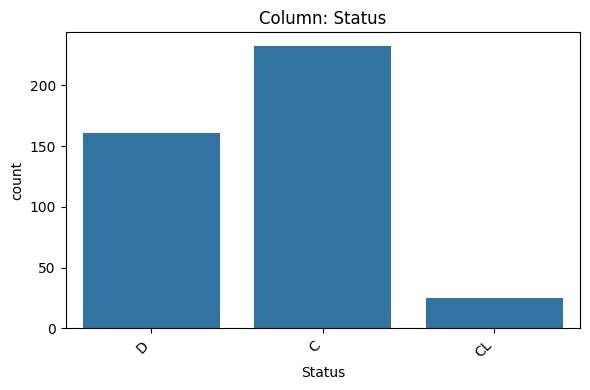

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'C' occurs 232 times (55.5%)
- Not constant or quasi-constant.


In [22]:
# ## Run the appropriate explore function (based on feature's dtype)
explore_categorical(df,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Its the target. It is a category.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - No null values to worry about.

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - 3 (low)




#Drug

Drug: type of drug D-penicillamine or placebo

In [23]:
feature = "Drug"
df[feature].dtype

dtype('O')

<ipython-input-4-8e7ee0b4def5>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


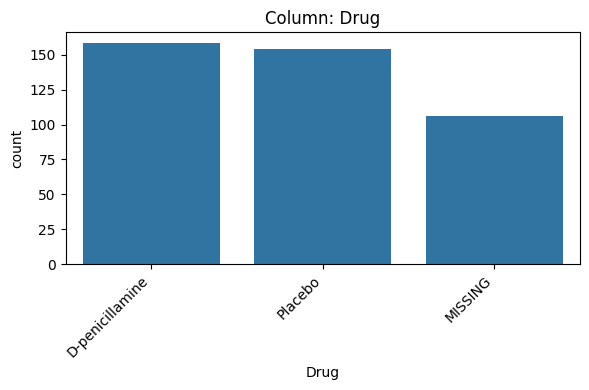

- NaN's Found: 106 (25.36%)
- Unique Values: 3
- Most common value: 'D-penicillamine' occurs 158 times (37.8%)
- Not constant or quasi-constant.


In [24]:
# ## Run the appropriate explore function (based on feature's dtype)
explore_categorical(df,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  -  It is a category.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 106 null values to worry about.
  - impuet with "missing"

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - 2 (low)




#Age

- Age: age in [days]

In [25]:
## Confirming the dtype to select correct EDA function
feature = "Age"
df[feature].dtype

dtype('int64')

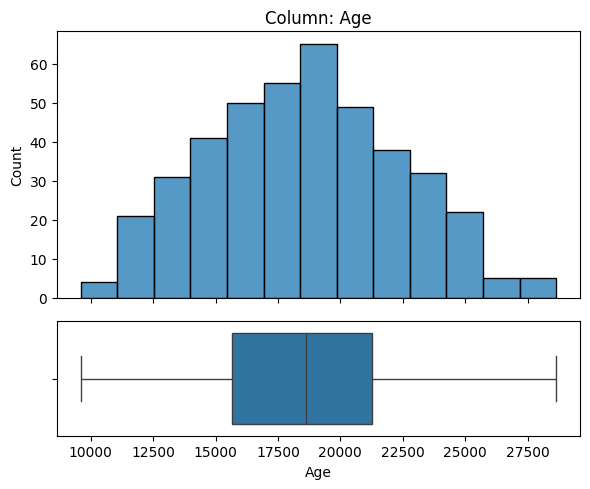

- NaN's Found: 0 (0.0%)


In [26]:
# ## Run the appropriate explore function (based on feature's dtype)
# explore_categorical(df,feature)
explore_numeric(df,feature)

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Numeric;

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0 null values

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - Not applicable (numeric).

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.


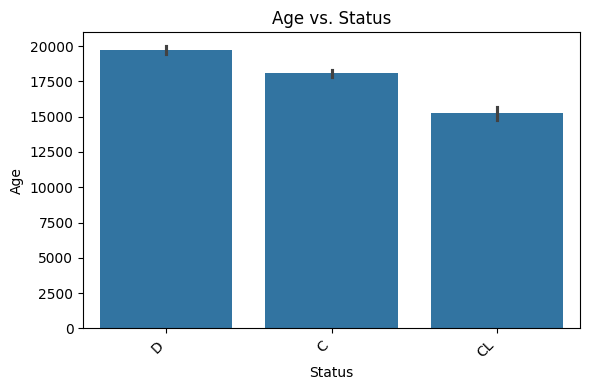

In [27]:
# ## Run the appropriate feature vs. target function (based on dtype)
# plot_categorical_vs_target(df, feature, 'Survived', target_type='class')
plot_numeric_vs_target(df, feature, "Status", target_type='class',
                       errorbar='se');

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - Yes. Would expect elderly = greater chance of died.

  - Does this feature appear to be a predictor of the target?
    - Maybe, there is a slight difference between the mean age of those that Status.

___

#Sex

- Sex: M (male) or F (female)

In [28]:
## Confirming the dtype to select correct EDA function
feature = "Sex"
df[feature].dtype

dtype('O')

<ipython-input-4-8e7ee0b4def5>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


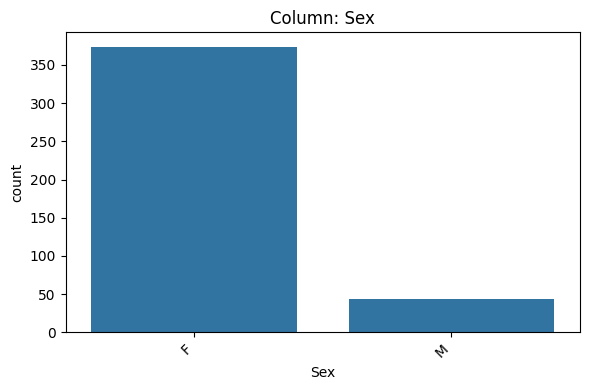

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'F' occurs 374 times (89.47%)
- Not constant or quasi-constant.


In [29]:
# ## Run the appropriate explore function (based on feature's dtype)
explore_categorical(df,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Categorical

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0 null values.

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - Low (n=2).

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



#Ascites

-  Ascites: presence of ascites N (No) or Y (Yes)

In [30]:
## Confirming the dtype to select correct EDA function
feature = 'Ascites'
df[feature].dtype

dtype('O')

<ipython-input-4-8e7ee0b4def5>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


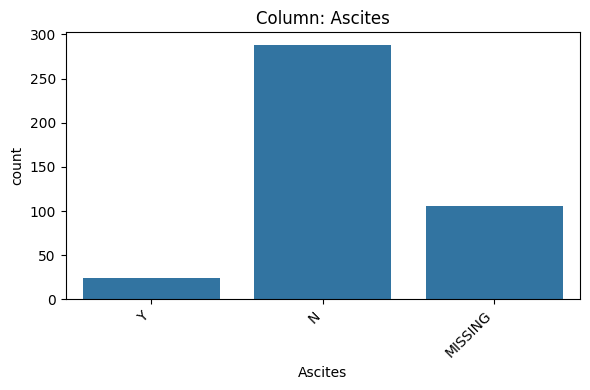

- NaN's Found: 106 (25.36%)
- Unique Values: 3
- Most common value: 'N' occurs 288 times (68.9%)
- Not constant or quasi-constant.


In [31]:
# ## Run the appropriate explore function (based on feature's dtype)
explore_categorical(df,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Categorical

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 106 null values.
  - imput with 'missing'

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - Low (n=2).

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



#Hepatomegaly

- Hepatomegaly: presence of hepatomegaly N (No) or Y (Yes)

In [32]:
## Confirming the dtype to select correct EDA function
feature = 'Hepatomegaly'
df[feature].dtype

dtype('O')

<ipython-input-4-8e7ee0b4def5>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


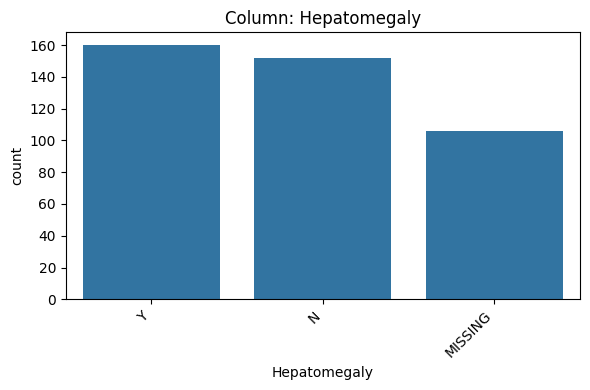

- NaN's Found: 106 (25.36%)
- Unique Values: 3
- Most common value: 'Y' occurs 160 times (38.28%)
- Not constant or quasi-constant.


In [33]:
# ## Run the appropriate explore function (based on feature's dtype)
explore_categorical(df,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Categorical

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 106 null values.
  - imput with 'missing'

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - Low (n=2).

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



#Spiders

- Spiders: presence of spiders N (No) or Y (Yes)

In [34]:
## Confirming the dtype to select correct EDA function
feature = "Spiders"
df[feature].dtype

dtype('O')

<ipython-input-4-8e7ee0b4def5>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


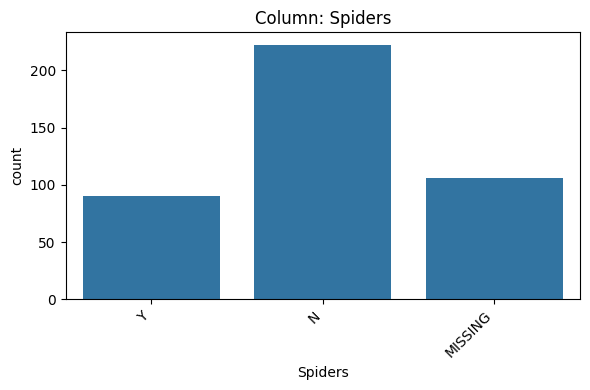

- NaN's Found: 106 (25.36%)
- Unique Values: 3
- Most common value: 'N' occurs 222 times (53.11%)
- Not constant or quasi-constant.


In [35]:
# ## Run the appropriate explore function (based on feature's dtype)
explore_categorical(df,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Categorical

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 106 null values.

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - Low (n=2).

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



#Edema

 - Edema: presence of edema  
 - N (no edema and no diuretic therapy for edema)
 - S (edema present without diuretics, or edema resolved by diuretics)
 - Y (edema despite diuretic therapy)

In [36]:
## Confirming the dtype to select correct EDA function
feature = "Edema"
df[feature].dtype

dtype('O')

<ipython-input-4-8e7ee0b4def5>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


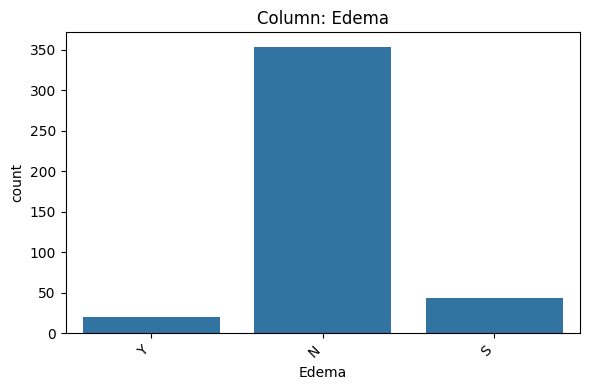

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'N' occurs 354 times (84.69%)
- Not constant or quasi-constant.


In [37]:
# ## Run the appropriate explore function (based on feature's dtype)
explore_categorical(df,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Categorical

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0 null values.

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - Low (n=3).

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



#Bilirubin

Bilirubin: serum bilirubin in [mg/dl]

In [38]:
## Confirming the dtype to select correct EDA function
feature = "Bilirubin"
df[feature].dtype

dtype('float64')

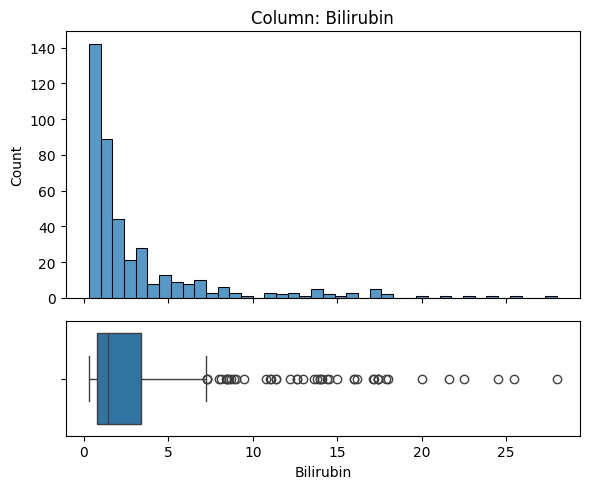

- NaN's Found: 0 (0.0%)


In [39]:
# ## Run the appropriate explore function (based on feature's dtype)
# explore_categorical(df,feature)
explore_numeric(df,feature)

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Numeric;

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - No null values

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - Not applicable (numeric).

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.


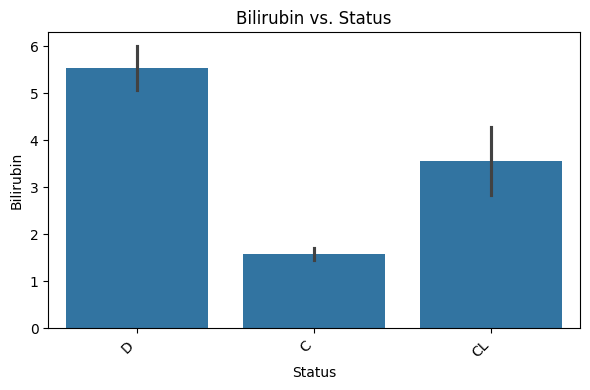

In [40]:
# ## Run the appropriate feature vs. target function (based on dtype)
# plot_categorical_vs_target(df, feature, 'Survived', target_type='class')
plot_numeric_vs_target(df, feature, 'Status', target_type='class',
                       errorbar='se');


- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - Yes. Would expect high Bilirubin  = greater chance of Died.

  - Does this feature appear to be a predictor of the target?
    - Maybe, there is a slight difference between the mean Bilirubin of those status.

___

#Cholesterol

- Cholesterol: serum cholesterol in [mg/dl]

In [41]:
## Confirming the dtype to select correct EDA function
feature = "Cholesterol"
df[feature].dtype

dtype('float64')

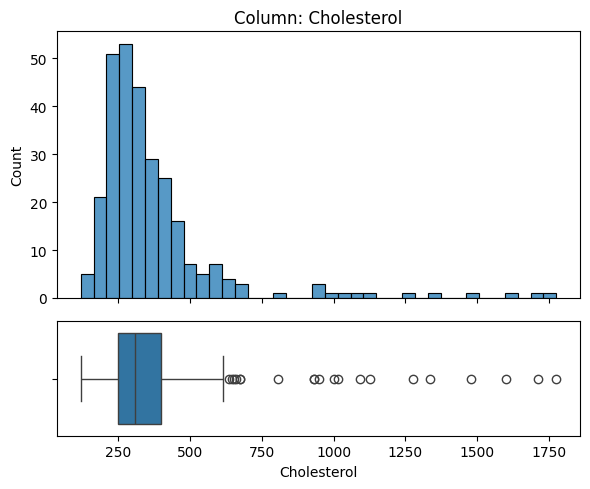

- NaN's Found: 134 (32.06%)


In [42]:
# ## Run the appropriate explore function (based on feature's dtype)
# explore_categorical(df,feature)
explore_numeric(df,feature)

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Numeric.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 134 null values.

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - Not applicable (numeric).

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



- Excluding 134 NaN's


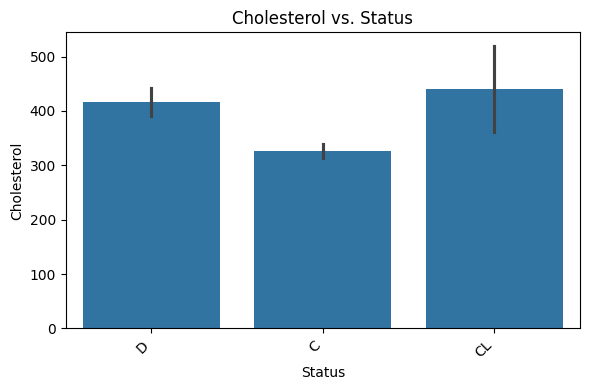

In [43]:
# ## Run the appropriate feature vs. target function (based on dtype)
# plot_categorical_vs_target(df, feature, 'Survived', target_type='class')
plot_numeric_vs_target(df, feature, 'Status', target_type='class',
                       errorbar='se');


- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - Yes, higher Cholesterol the  patient will be more under censored
  - Does this feature appear to be a predictor of the target?
    - Yes,the differansis in mean of cholesterol is good .

___

#Albumin

-  Albumin: albumin in [gm/dl]

In [44]:
## Confirming the dtype to select correct EDA function
feature = "Albumin"
df[feature].dtype

dtype('float64')

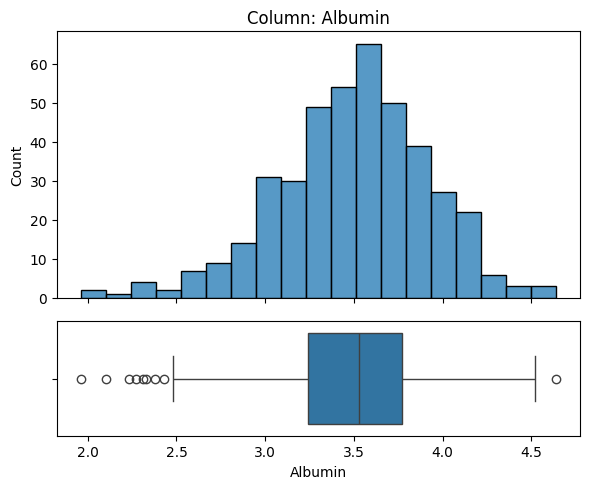

- NaN's Found: 0 (0.0%)


In [45]:
# ## Run the appropriate explore function (based on feature's dtype)
explore_numeric(df,feature)

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Numeric.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0 null values.

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - Not applicable (numeric).

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



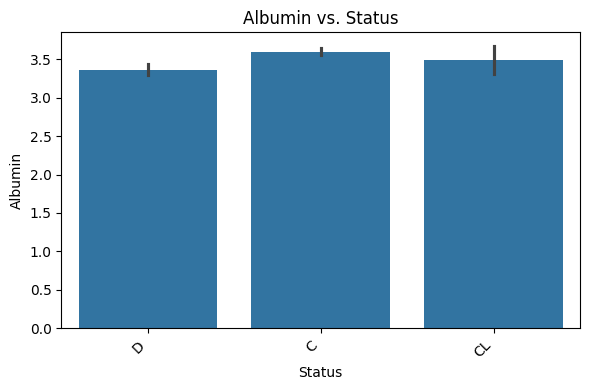

In [46]:
# ## Run the appropriate feature vs. target function (based on dtype)
plot_numeric_vs_target(df, feature, 'Status', target_type='class');

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - Maybe, because mean aibumin is reltivly matchs in each status.
  - Does this feature appear to be a predictor of the target?
    - maybe,ther no differanc in mean Albumin for status .

___

#Copper

-  Copper: urine copper in [ug/day]

In [47]:
## Confirming the dtype to select correct EDA function
feature = "Copper"
df[feature].dtype

dtype('float64')

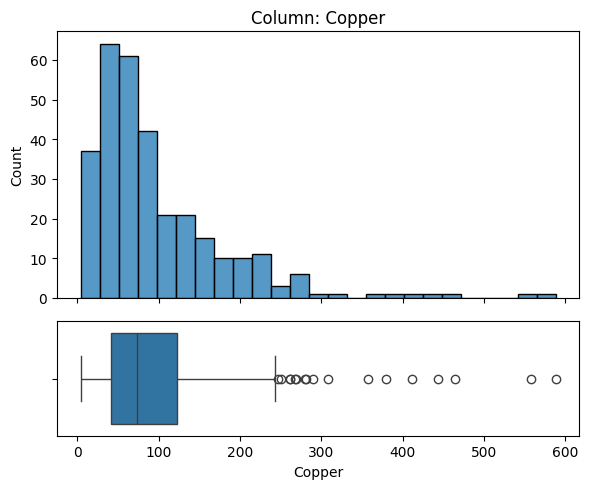

- NaN's Found: 108 (25.84%)


In [48]:
# ## Run the appropriate explore function (based on feature's dtype)
# explore_categorical(df,feature)
explore_numeric(df,feature)

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Numeric.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 108 null values.

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - Not applicable (numeric).

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



- Excluding 108 NaN's


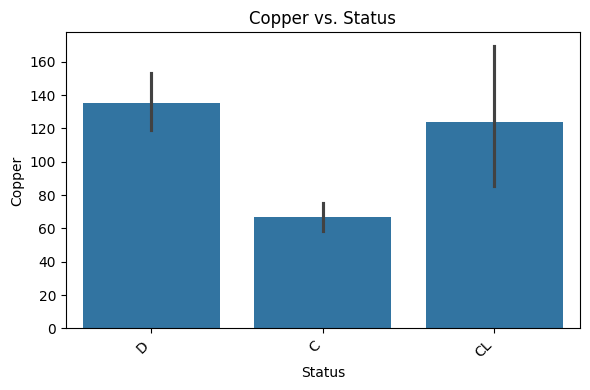

In [49]:
# ## Run the appropriate feature vs. target function (based on dtype)
plot_numeric_vs_target(df, feature, 'Status', target_type='class');

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - yas, because the higher in copper the patiant will be under conserd.
  - Does this feature appear to be a predictor of the target?
    - yas,ther is an effect on patint and if the copper is increserd it's will be a dengers  .

___

#Alk_Phos

-  Alk_Phos: alkaline phosphatase in [U/liter]

In [50]:
## Confirming the dtype to select correct EDA function
feature = "Alk_Phos"
df[feature].dtype

dtype('float64')

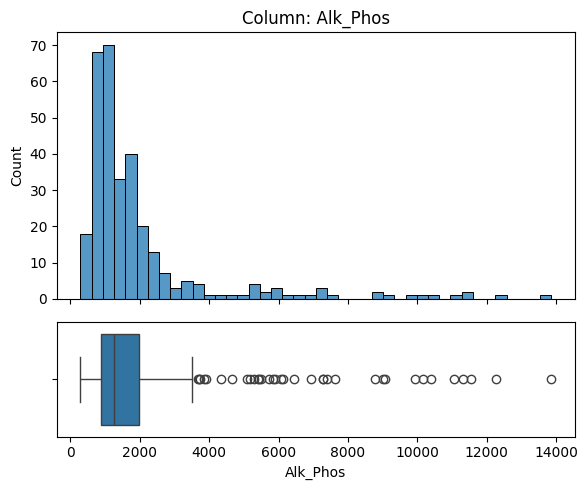

- NaN's Found: 106 (25.36%)


In [51]:
# ## Run the appropriate explore function (based on feature's dtype)
# explore_categorical(df,feature)
explore_numeric(df,feature)

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Numeric.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 106 null values.

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - Not applicable (numeric).

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



- Excluding 106 NaN's


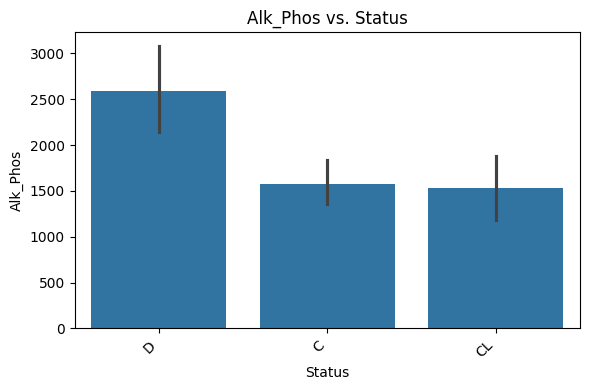

In [52]:
# ## Run the appropriate feature vs. target function (based on dtype)
plot_numeric_vs_target(df, feature, 'Status', target_type='class');

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - maybe,died status is incresed if mean of Alk_phos is incresed,and ther is a no big differance in C,CL status.
  - Does this feature appear to be a predictor of the target?
    - There is difficulty in distinguishing in C,CL status
___

#SGOT

-  SGOT: SGOT in [U/ml]

In [53]:
## Confirming the dtype to select correct EDA function
feature = "SGOT"
df[feature].dtype

dtype('float64')

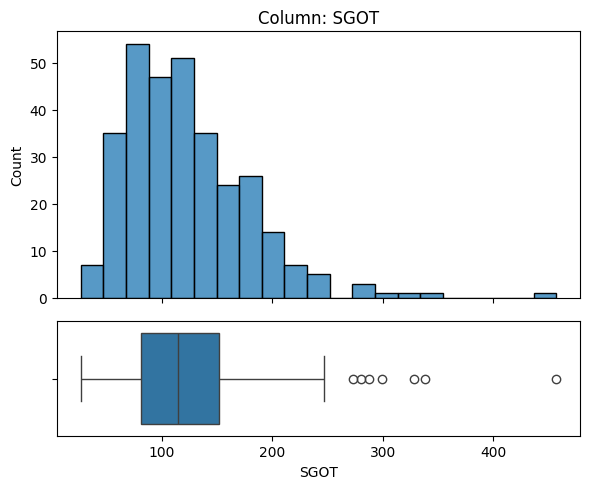

- NaN's Found: 106 (25.36%)


In [54]:
# ## Run the appropriate explore function (based on feature's dtype)
# explore_categorical(df,feature)
explore_numeric(df,feature)

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Numeric.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 106 null values.

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - Not applicable (numeric).

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



- Excluding 106 NaN's


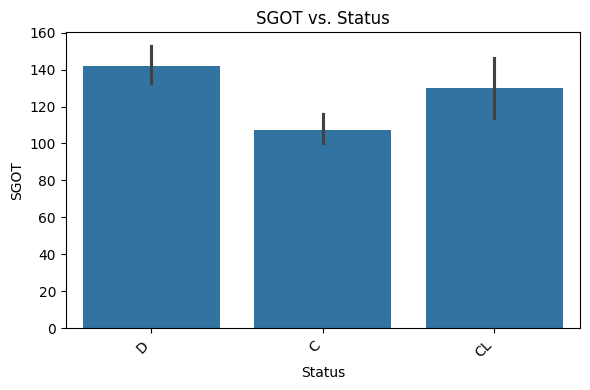

In [55]:
# ## Run the appropriate feature vs. target function (based on dtype)
plot_numeric_vs_target(df, feature, 'Status', target_type='class');

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - yas,there is an reltivly differaces on status
  - Does this feature appear to be a predictor of the target?
    - yas, it is apper that higher SGOT for pataint but them under consedrd
___

#Tryglicerides

- Triglycerides: triglicerides in [mg/dl]

In [56]:
## Confirming the dtype to select correct EDA function
feature = "Tryglicerides"
df[feature].dtype

dtype('float64')

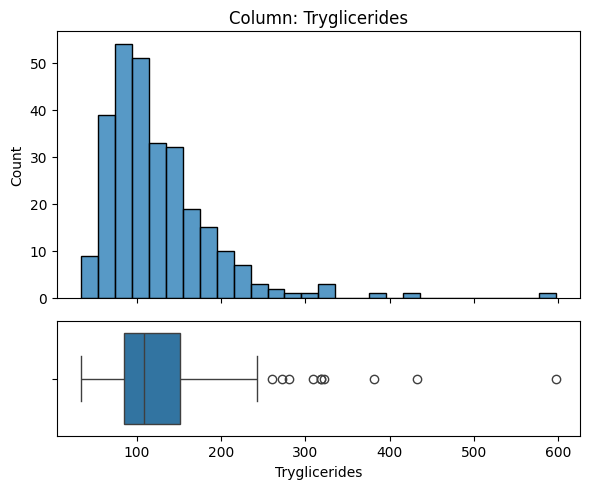

- NaN's Found: 136 (32.54%)


In [57]:
# ## Run the appropriate explore function (based on feature's dtype)
# explore_categorical(df,feature)
explore_numeric(df,feature)

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Numeric.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 136 null values.

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - Not applicable (numeric).

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



- Excluding 136 NaN's


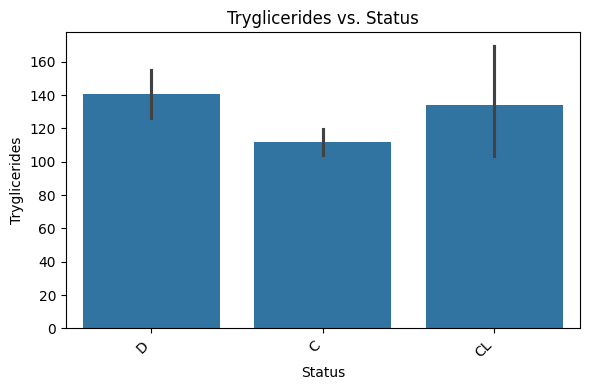

In [58]:
# ## Run the appropriate feature vs. target function (based on dtype)
plot_numeric_vs_target(df, feature, 'Status', target_type='class');

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - may,there is an reltivly differaces on status
  - Does this feature appear to be a predictor of the target?
    - may, it is apper that mean of  Tryglicerides for pataint is difficult to distinguishing the status
___

#Platelets

- Platelets: platelets per cubic [ml/1000]

In [59]:
## Confirming the dtype to select correct EDA function
feature = "Platelets"
df[feature].dtype

dtype('float64')

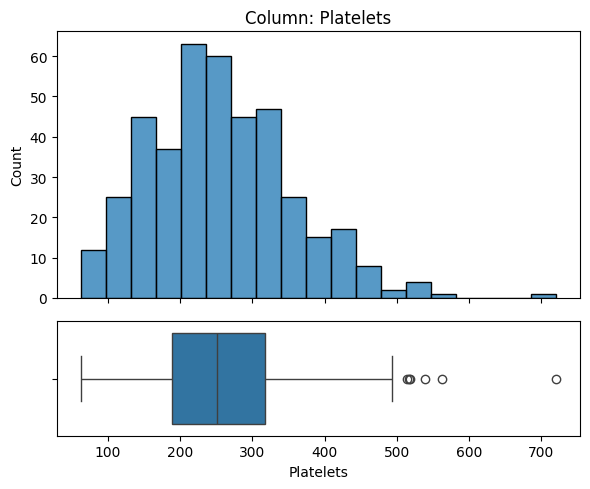

- NaN's Found: 11 (2.63%)


In [60]:
# ## Run the appropriate explore function (based on feature's dtype)
# explore_categorical(df,feature)
explore_numeric(df,feature)

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Numeric.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 11 null values.

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - Not applicable (numeric).

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



- Excluding 11 NaN's


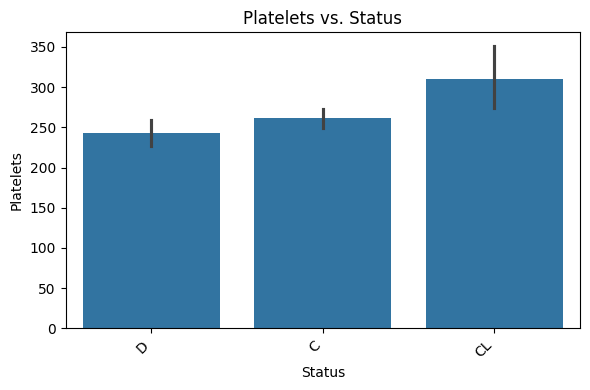

In [61]:
# ## Run the appropriate feature vs. target function (based on dtype)
plot_numeric_vs_target(df, feature, 'Status', target_type='class');

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - yas,there is an reltivly differaces on status, if the Platelets is higher than the averge the patint status is CL  
  - Does this feature appear to be a predictor of the target?
    - may, it is apper there is a diffuclt to distinguishing the
     pataint status
___

#Prothrombin

-  Prothrombin: prothrombin time in seconds [s]

In [62]:
## Confirming the dtype to select correct EDA function
feature = "Prothrombin"
df[feature].dtype

dtype('float64')

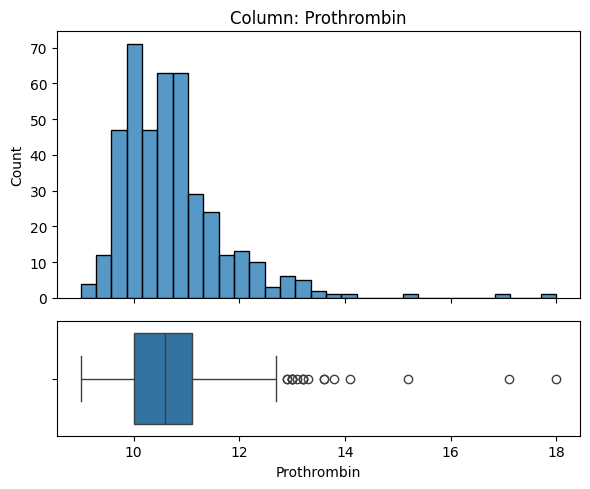

- NaN's Found: 2 (0.48%)


In [63]:
# ## Run the appropriate explore function (based on feature's dtype)
# explore_categorical(df,feature)
explore_numeric(df,feature)

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Numeric.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 2 null values.

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - Not applicable (numeric).

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



- Excluding 2 NaN's


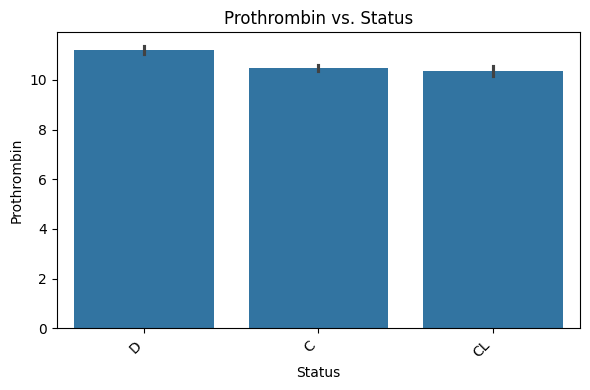

In [64]:
# ## Run the appropriate feature vs. target function (based on dtype)
plot_numeric_vs_target(df, feature, 'Status', target_type='class');

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - may,there is an reltivly differaces on status
  - Does this feature appear to be a predictor of the target?
    - may, it is apper there is a diffuclt to distinguishing the
     pataint status
___

### Stage

- Stage: histologic stage of disease (1, 2, 3, or 4)
    - 1 = 1st =  Lower
    - 2 = 2nd =  Good
    - 3 = 3rd = Middle
    - 4 = 4th = Upper

In [65]:
## Confirming the dtype to select correct EDA function
feature = "Stage"
df[feature].dtype

dtype('float64')

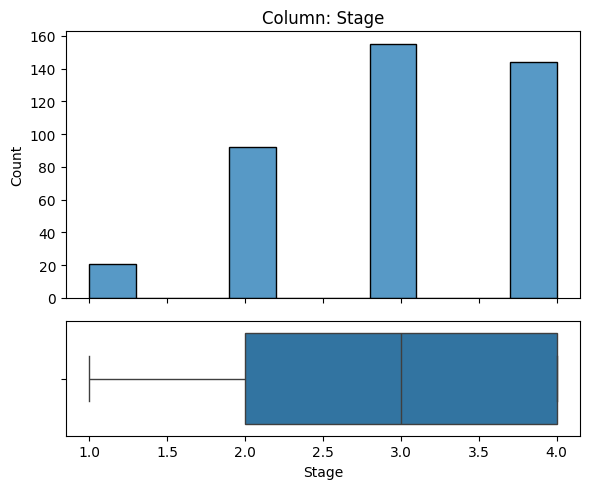

- NaN's Found: 6 (1.44%)


In [66]:
# ## Run the appropriate explore function (based on feature's dtype)
explore_numeric(df,feature)

<ipython-input-4-8e7ee0b4def5>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


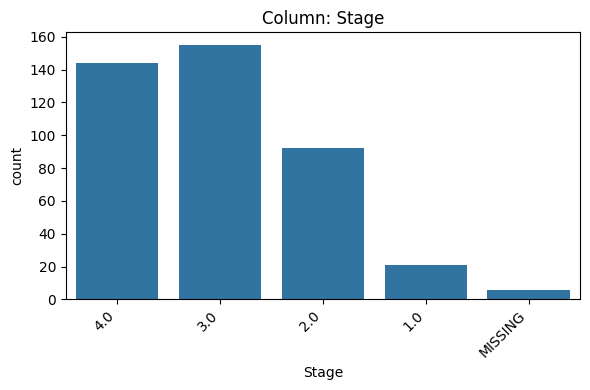

- NaN's Found: 6 (1.44%)
- Unique Values: 5
- Most common value: '3.0' occurs 155 times (37.08%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Stage'}, xlabel='Stage', ylabel='count'>)

In [67]:
explore_categorical(df,feature)

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Its technically ordinal, but could be processed as numeric or turned into OneHotEncoded categories.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 6 null values to worry about.
  -  impute with "missing".

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - Low (n=4)

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No, this is an important feature to include.



- Excluding 6 NaN's


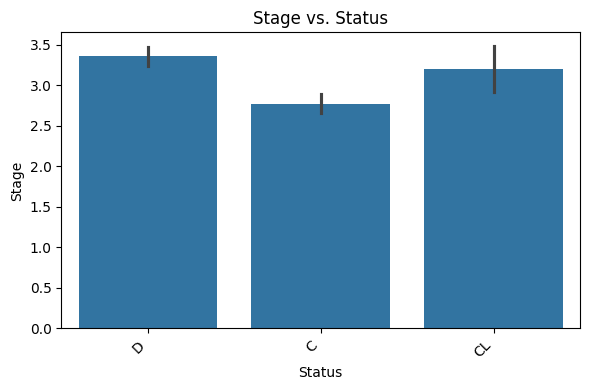

In [68]:
plot_numeric_vs_target(df, feature, "Status", target_type='class');

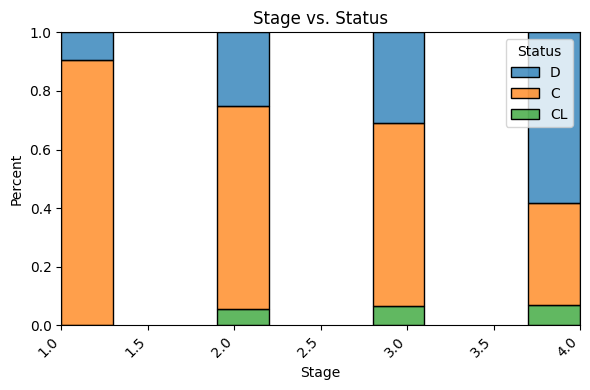

In [69]:
# ## Run the appropriate feature vs. target function (based on dtype)
plot_categorical_vs_target(df, feature, 'Status', target_type='class',fillna=False);

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - Yes, it looks like first class had the no CL patient and for other class it's relativly close to each other .
    - most of D patient is in class 4
    -  most of C patient is in class 1
  - Does this feature appear to be a predictor of the target?
    - Yes.

___

#Model Building

In [70]:
# Define target
target_col = "Status"


# Define X and y
y = df[target_col].copy()
X = df.drop(columns=[target_col]).copy()

# Train test split
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=321)



<ipython-input-71-6cbaa00da1af>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = pd.concat([X, pd.DataFrame(y, columns=["Status"])], axis=1).corr()


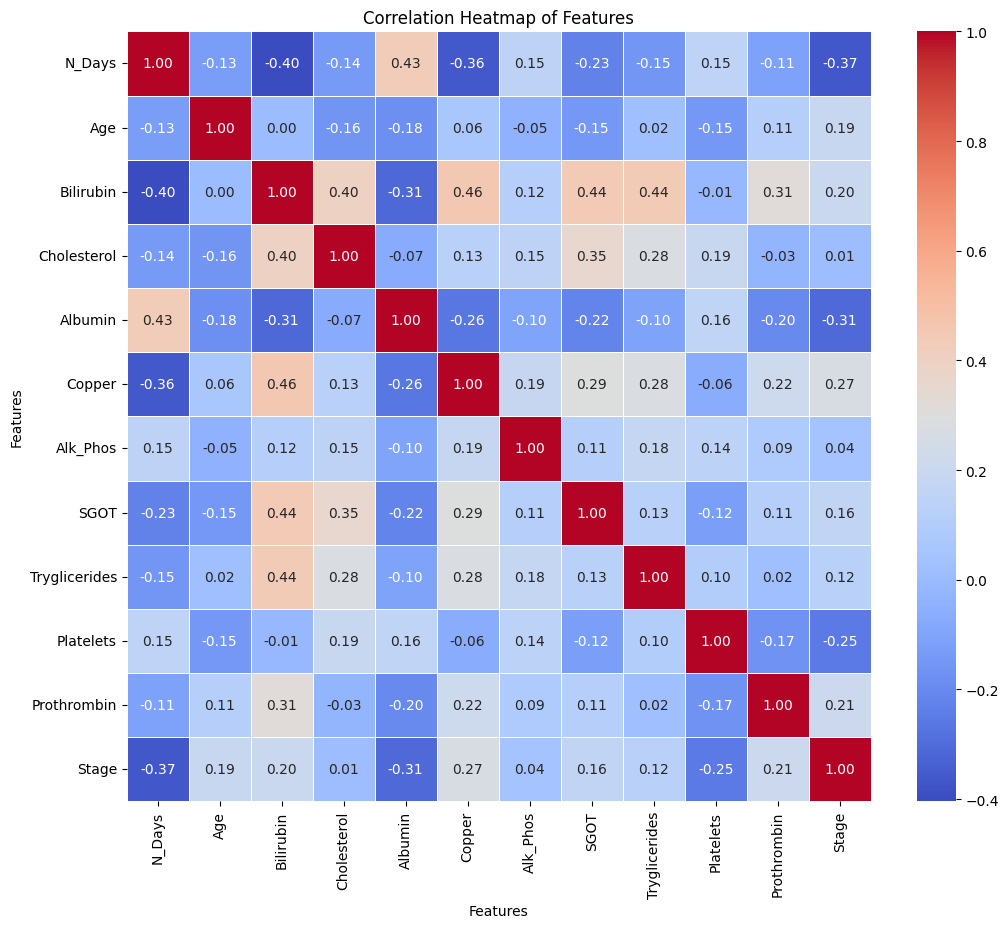

In [71]:
# Calculating correlation matrix
correlation_matrix = pd.concat([X, pd.DataFrame(y, columns=["Status"])], axis=1).corr()

# Plotting a heatmap to visualize correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

Strong Correlations with 'Status':
- N_Days(.29)
- Bilirubin(-.34)
- prothrombin(-.33)


In [72]:
X_train.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,
264,1542,Placebo,16122,F,N,Y,Y,N,3.4,356.0,3.12,188.0,1911.0,92.00,130.0,318.0,11.2,3.0
273,1558,Placebo,17320,F,N,N,Y,N,2.2,328.0,3.46,75.0,1677.0,87.00,116.0,202.0,9.6,3.0
301,1295,Placebo,16513,F,N,N,N,N,1.0,393.0,3.57,50.0,1307.0,74.00,103.0,295.0,10.5,4.0
86,1657,D-penicillamine,19270,F,N,Y,Y,N,5.0,1600.0,3.21,75.0,2656.0,82.15,174.0,181.0,10.9,3.0
286,1408,D-penicillamine,14191,F,N,Y,Y,N,2.0,310.0,3.36,70.0,1257.0,122.00,118.0,143.0,9.8,3.0


In [73]:
y_train.head()

ID
264    CL
273     C
301     C
86      D
286     C
Name: Status, dtype: object

In [74]:
X_train.isna().sum()

N_Days            0
Drug             74
Age               0
Sex               0
Ascites          74
Hepatomegaly     74
Spiders          74
Edema             0
Bilirubin         0
Cholesterol      95
Albumin           0
Copper           76
Alk_Phos         74
SGOT             74
Tryglicerides    97
Platelets         8
Prothrombin       2
Stage             4
dtype: int64

In [75]:
# Categorical Preprocessing Pipeline
# Save list of column names
ohe_cols = X_train.select_dtypes('object').columns
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='constant', fill_value = "NA")
# Instantiate the individual preprocessors
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline( impute_na,ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical',ohe_pipe, ohe_cols)
#________________________________________________________________________
# Numerical Prepprocessing Pipeline
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
impute_na = SimpleImputer(strategy='constant', fill_value = 0)
# instantiate preprocessors
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline( impute_na,scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)
#_________________________________________________________________


In [76]:
# Create the Column Transformer
prepprocessing=ColumnTransformer([num_tuple,ohe_tuple],verbose_feature_names_out=True)
prepprocessing

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object'))])

In [77]:
prepprocessing.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object'))])

In [78]:
# Transform the training data
X_train_processed = prepprocessing.transform(X_train)
# Transform the testing data
X_test_processed = prepprocessing.transform(X_test)
# View the processed training data
X_train_processed.head()



,numeric__N_Days,numeric__Age,numeric__Bilirubin,numeric__Cholesterol,numeric__Albumin,numeric__Copper,numeric__Alk_Phos,numeric__SGOT,numeric__Tryglicerides,numeric__Platelets,numeric__Prothrombin,numeric__Stage,categorical__Drug_D-penicillamine,categorical__Drug_NA,categorical__Drug_Placebo,categorical__Sex_F,categorical__Sex_M,categorical__Ascites_N,categorical__Ascites_NA,categorical__Ascites_Y,categorical__Hepatomegaly_N,categorical__Hepatomegaly_NA,categorical__Hepatomegaly_Y,categorical__Spiders_N,categorical__Spiders_NA,categorical__Spiders_Y,categorical__Edema_N,categorical__Edema_S,categorical__Edema_Y
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
264,-0.302035,-0.685826,0.024908,0.349661,-0.864815,1.244767,0.164428,-0.052198,0.538956,0.699685,0.377487,-0.020418,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
273,-0.286935,-0.367328,-0.243156,0.245800,-0.038809,-0.030245,0.055278,-0.121075,0.363859,-0.441972,-0.790903,-0.020418,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
301,-0.535145,-0.581875,-0.511220,0.486907,0.228428,-0.312327,-0.117310,-0.300157,0.201269,0.473322,-0.133684,1.044725,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
86,-0.193502,0.151096,0.382327,4.964079,-0.646166,-0.030245,0.511935,-0.187887,1.089260,-0.648652,0.158414,-0.020418,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
286,-0.428499,-1.199198,-0.287833,0.179032,-0.281752,-0.086661,-0.140632,0.361068,0.388873,-1.022643,-0.644854,-0.020418,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [79]:
y_train.value_counts()

C     173
D     123
CL     17
Name: Status, dtype: int64

In [80]:
from imblearn.over_sampling import SMOTE,SMOTENC
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train_processed , y_train)
y_train_sm.value_counts()

CL    173
C     173
D     173
Name: Status, dtype: int64

In [81]:
rf_cls = RandomForestClassifier(random_state = 321)
rf_cls.fit(X_train_sm, y_train_sm)

RandomForestClassifier(random_state=321)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       1.00      1.00      1.00       173
          CL       1.00      1.00      1.00       173
           D       1.00      1.00      1.00       173

    accuracy                           1.00       519
   macro avg       1.00      1.00      1.00       519
weighted avg       1.00      1.00      1.00       519



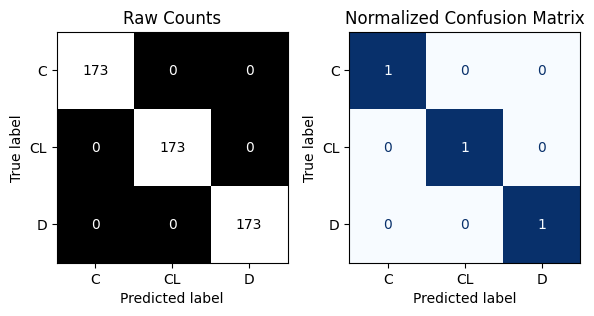


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.78      0.92      0.84        59
          CL       0.29      0.25      0.27         8
           D       0.72      0.55      0.63        38

    accuracy                           0.73       105
   macro avg       0.60      0.57      0.58       105
weighted avg       0.72      0.73      0.72       105



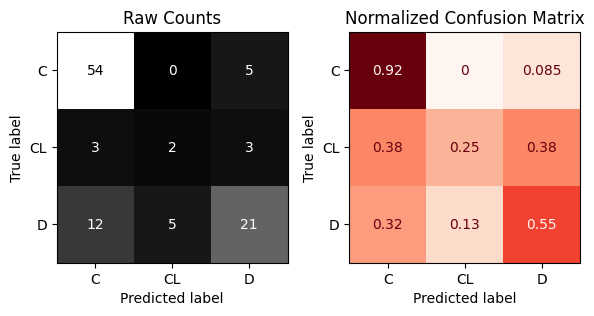

In [82]:
#use costum function to evaluate model befor pridctution
evaluate_classification(rf_cls, X_train_sm, y_train_sm, X_test_processed, y_test)

- The model performs exceptionally well on the training data, achieving perfect precision, recall, and F1-score for each class.

- On the test data, the performance is still decent, but there are variations in precision, recall, and F1-score for each class, indicating some challenges in predicting certain classes.

#important features

In [83]:
feature_names = prepprocessing.get_feature_names_out()
feature_importance = pd.Series(rf_cls.feature_importances_, index=feature_names,
                        name='logreg Feature Importances')
feature_importance.head()

numeric__N_Days         0.090840
numeric__Age            0.154283
numeric__Bilirubin      0.134446
numeric__Cholesterol    0.036846
numeric__Albumin        0.042108
Name: logreg Feature Importances, dtype: float64

## Apply sklearn's permutation importance and visualize the permutation importances.


In [84]:
from sklearn.inspection import permutation_importance

r = permutation_importance(rf_cls, X_train_processed, y_train ,n_repeats =5, random_state = 321)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [85]:
## can make the mean importances into a series
perm_importances = pd.Series(r['importances_mean'],index=X_train_sm.columns,
                           name = 'permutation importance')
perm_importances.head()

numeric__N_Days         0.031310
numeric__Age            0.070288
numeric__Bilirubin      0.076677
numeric__Cholesterol    0.001917
numeric__Albumin        0.001278
Name: permutation importance, dtype: float64

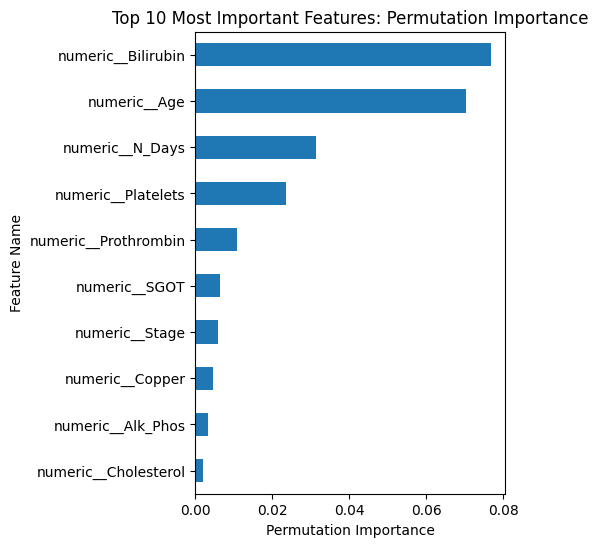

In [86]:
ax = perm_importances.sort_values().tail(10).plot(kind='barh',figsize=(4,6))
ax.set(ylabel='Feature Name',xlabel='Permutation Importance',
       title='Top 10 Most Important Features: Permutation Importance');

TypeError: can't multiply sequence by non-int of type 'float'

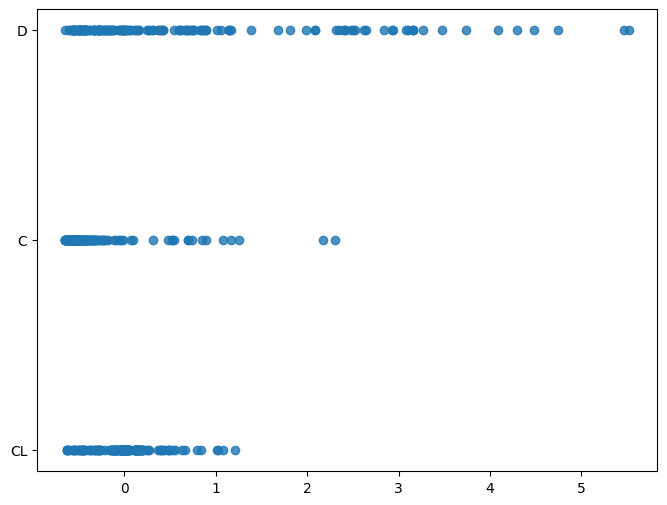

In [88]:
perm_importance = r

# Extract the top 10 features based on permutation importances
top_features_indices = perm_importance.importances_mean.argsort()[-10:][::-1]
top_features_names = X_train_sm.columns[top_features_indices]

# Select 2 out of the top 10 features
selected_features = top_features_names[:2]

# Create explanatory visualizations for the selected features
for feature in selected_features:
    # Scatter plot or other visualizations to show the relationship with the target
    plt.figure(figsize=(8, 6))
    sns.regplot(x=X_train_sm[feature], y=y_train_sm)
    plt.title(f"Relationship between {feature} and Target")
    plt.xlabel(feature)
    plt.ylabel("Target Variable")
    plt.show()

looks like this two faetuers have a negative relation with target value
so we can say ifnumeric__Age and numeric__Bilirubin are raised the pathological status will be in dangers

#Project 4 - Part 2 (Core)


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [ ]:
#do we need to put the taregt value y
X_cluster=pd.concat([X_train_processed,X_test_processed])
X_cluster.head()

In [ ]:
min_samples = 10
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors.fit(X_cluster)
distances, indices = neighbors.kneighbors(X_cluster)
distances[:5]



In [ ]:
# Obtain the furthest distance for each point
farthest_distances = distances[:, -1]
# Sort the furthest distance for each point
sorted_distances = np.sort(farthest_distances)
sorted_distances[0:5]



In [ ]:
# Plot the distances required for points to be included in a cluster with min sample of 20
plt.plot(sorted_distances)
plt.xlabel("Number of Points")
plt.ylabel("Distance to 19th Neighbor")
plt.show()

In [ ]:
# Instantiate & fit clustering - this is done in one step for DBSCAN
dbs = DBSCAN(eps = 3.8, min_samples = min_samples).fit(X_cluster)

In [ ]:
# Save the cluster labels to the dataframe
df['cluster'] = dbs.labels_
df.head()

In [ ]:
df['Age_groub'] = df['Age'].apply(lambda x: 'elderly' if x > 30 else 'young')
df.head()


In [ ]:
#convert age from days to years
df["Age"]=df['Age'].apply(lambda age: (age/365)).round(-1)
df.head()

In [ ]:
# Define target
target_col = "Status"


# Define X and y
y = df[target_col].copy()
X = df.drop(columns=[target_col]).copy()

# Train test split
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=321)



In [ ]:
X_train.head()

In [ ]:
# Categorical Preprocessing Pipeline
# Save list of column names
ohe_cols = X_train.select_dtypes('object').columns
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='constant', fill_value = "NA")
# Instantiate the individual preprocessors
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline( impute_na,ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical',ohe_pipe, ohe_cols)
#________________________________________________________________________
# Numerical Prepprocessing Pipeline
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
impute_na = SimpleImputer(strategy='constant', fill_value = 0)
# instantiate preprocessors
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline( impute_na,scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)
#_________________________________________________________________


In [ ]:
# Create the Column Transformer
prepprocessing=ColumnTransformer([num_tuple,ohe_tuple],verbose_feature_names_out=True)
prepprocessing

In [ ]:
# Transform the training data
X_train_processed = prepprocessing.fit_transform(X_train)
# Transform the testing data
X_test_processed = prepprocessing.fit_transform(X_test)
# View the processed training data
X_train_processed.head()



In [ ]:
y_train.value_counts()


In [ ]:
from imblearn.over_sampling import SMOTE,SMOTENC
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train_processed , y_train)
y_train_sm.value_counts()

In [ ]:
rf_clr=RandomForestClassifier(random_state=321)
rf_clr.fit(X_train_sm,y_train_sm)


In [ ]:
#use costum function to evaluate model befor pridctution
evaluate_classification(rf_clr, X_train_sm, y_train_sm,X_test_processed, y_test)